# 1.0 Computer Vision for Crop Disease Detection

## Defining the question

### Specifying the Question

Create an image recognition model to detect wheat rust. Model to recognize if:
- Wheat is healthy
- Has stem rust 
- Leaf rust.

Classifier algorithm used is Artificial Neural Networks.

The model will enable facilitate monitoring of wheat crops and detect presence of wheat rust on stem or leaves through avenues such as smartphone images.
This will be a major breakthrough in the ability to monitor and control plant diseases like wheat rust that affect African livelihoods. 

Currently, the farmers are dependent on agricultral proffessionals such as extension officers or agrovets for advise. These proffessionals are not easily accessible due to cost or lack of government extension services.


### Metric for success
- Log Loss
- AUC- area under the curve

### Understanding the context
What is wheat rust?

Is a plant disease that affects wheat. If affects any above-ground plant mainly stem, leaves sheaths, glumes, awns and even seed, leading to the production of pustules that contain thousands of dry yellow-orange to reddish-brown or black spores. These pustules give the appearance of “rust” on the plant.

What causes wheat rust?

Is caused by rust fungi. Water on the leaf surface from intermittent rains or heavy dews and temperatures conducive for germination and growth of the pathogen are required for disease development.

What is the impact of wheat rust?
Reducing crop yields and hence affecting the livelihoods of farmers and decreasing food security across the continent. 

How to Manage Rust?
- Spray fungicides
- Destroy infected crop
- Field Scouting


Prevention
- Plant rust resistant crops
- Destroy infected crops to avoid spread.

Preventing the disease totally is not possible in all scenarios because:
- Constant changes in strains (races) of the pathogens
- In many situations, the varieties remained resistant for only three to four years before showing signs of susceptibility

### Recording the experimental design

CRISP- DM methodology will be applied. Below steps will be undertaken to create the classifer.

- Business understanding - understanding the background
- Data understanding 
- Exploratory data analysis
- Feature engineering
- Data modelling
- Model interpretation

### Data relevance
Data is sourced from Zindi a datascience competition platform. In turn, the data was availed to Zindi by 
Bulk of the data was collected in-field by CIMMYT(International Maize and Wheat Improvement Center) which is a non-profit research and training institution dedicated to development of improved varieties of wheat and maize as well as CIMMYT partners in Ethiopia and Tanzania. 

Remainder of the data was sourced from public images found on Google Images.


## 2.0 Libraries Importation

In [1]:
#Data Manipulation Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import re #regular expressions
#Progress bar
from tqdm import tqdm

from datetime import datetime

#Read Images
import os
from skimage import io
from PIL import Image
# import cv2 # When open cv was used, there was an error in getting array from image. Using Pillow eliminated the error.

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Model Pre-processing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Modelling
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import  r2_score,roc_auc_score,f1_score,recall_score,precision_score,classification_report, confusion_matrix,log_loss

Using TensorFlow backend.


In [2]:
# Increase rows and columns visible on the notebook
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 50)

# import required libraries
import warnings
warnings.filterwarnings("ignore")

## 3.0 Import Images

Import the train images from the 3 image directories. The three directories  are healthy_wheat, stem_rust and leaf_rust. Each of the directory has images which are healthy or have rust on either the stem or leaf. Therebeing, the name of the directory corresponds will be marked as the label of the image.

### a) Image height, width and channel exploration

In [3]:
#Function to upload the Raw training images
def upload_raw_train_images(image_path, wheat_categories):
    images = []   
    labels = []
    # Loop across the three directories having wheat images.
    for category in wheat_categories:  
        print("Category:",category)
        # Append the wheat category directory into the main path
        full_image_path = image_path +  category + "/"
        # Retrieve the filenames from the all the three wheat directories. OS package used.
        image_file_names = [os.path.join(full_image_path, f) for f in os.listdir(full_image_path)]
        # Read the image pixels
        for file in image_file_names[0:5]:
            image=io.imread(file) #io package from SKimage package
            print(image.shape)
            images.append(np.array(image))
            labels.append(category)
    return images, labels
wheat_categories = ['healthy_wheat', 'stem_rust', 'leaf_rust'] 
raw_train_images, raw_train_labels = upload_raw_train_images('/kaggle/input/cgiar-computer-vision-for-crop-disease/ICLR/train/train/',wheat_categories)

Category: healthy_wheat
(3264, 1836, 3)
(194, 259, 3)
(3264, 1836, 3)
(225, 225, 3)
(182, 277, 3)
Category: stem_rust
(2848, 4272, 3)
(4272, 2848, 3)
(1836, 3264, 3)
(3264, 1836, 3)
(177, 285, 3)
Category: leaf_rust
(194, 259, 3)
(224, 224, 3)
(194, 259, 3)
(1133, 850, 3)
(1067, 800, 3)


We loaded the raw images for processing but encountered memory challenges. The training images took 15.5GB of ram out of available 16GB. We therefore took an decision to resize the images to 256 by 256.


**Rationale**
Initially, we resized to 30 by 30 but the images became too distorted/dull. We increased to 512 but encountered computational challenges during modelling whereby GPU memory capacity(16GB) was being exhausted. 
Optimal size was hence found to be 256 by 256.

Images observed to be of channel 3. Visual exploration also confirms they are coloured

### b) Resized Training images upload

In [4]:
#Function to upload the resized training images
def upload_train_images(image_path, wheat_categories ,height, width):
    images = []
    labels = []
    
    # Loop across the three directories having wheat images.
    for category in wheat_categories:
        
        # Append the wheat category directory into the main path
        full_image_path = image_path +  category + "/"
        # Retrieve the filenames from the all the three wheat directories. OS package used.
        image_file_names = [os.path.join(full_image_path, f) for f in os.listdir(full_image_path)]
        # Read the image pixels
        for file in image_file_names:
            image=io.imread(file) #io package from SKimage package
            # Append image into list
            image_from_array = Image.fromarray(image, 'RGB')
            #Resize image
            size_image = image_from_array.resize((height, width))
            #Append image into list
            images.append(np.array(size_image))
            # Label for each image as per directory
            labels.append(category)
        
    return images, labels

## Invoke the function
#Image resize parameters
height = 256
width = 256
#Get number of classes
wheat_categories = ['healthy_wheat', 'stem_rust', 'leaf_rust'] 
train_images, train_labels = upload_train_images('/kaggle/input/cgiar-computer-vision-for-crop-disease/ICLR/train/train/',wheat_categories,height,width)
#Size and dimension of output image and labels
train_images = np.array(train_images)
train_labels = np.array(train_labels)

Check the count and size of images uploaded

In [5]:
print("Shape of training images is " + str(train_images.shape))
print("Shape of training labels is " + str(train_labels.shape))

Shape of training images is (876, 256, 256, 3)
Shape of training labels is (876,)


### c) Display sample training images

a) Individual images

Train images, sizes and cass labels


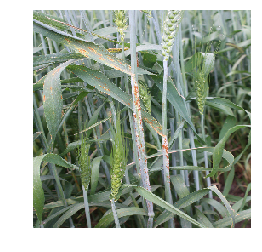

Size of this image is (256, 256, 3)
Class of the image is stem_rust


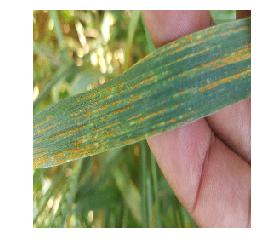

Size of this image is (256, 256, 3)
Class of the image is leaf_rust


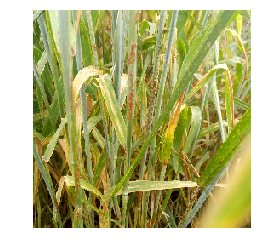

Size of this image is (256, 256, 3)
Class of the image is leaf_rust


In [6]:
def show_train_images(images, labels, images_count):
     for i in range(images_count):
        
        index = int(random.random() * len(images))
        plt.axis('off')
        plt.imshow(images[index])
        plt.show()
        
        print("Size of this image is " + str(images[index].shape))
        print("Class of the image is " + str(labels[index]))

#Execute the function
print("Train images, sizes and cass labels")
show_train_images(train_images, train_labels, 3)

b) Display batch images

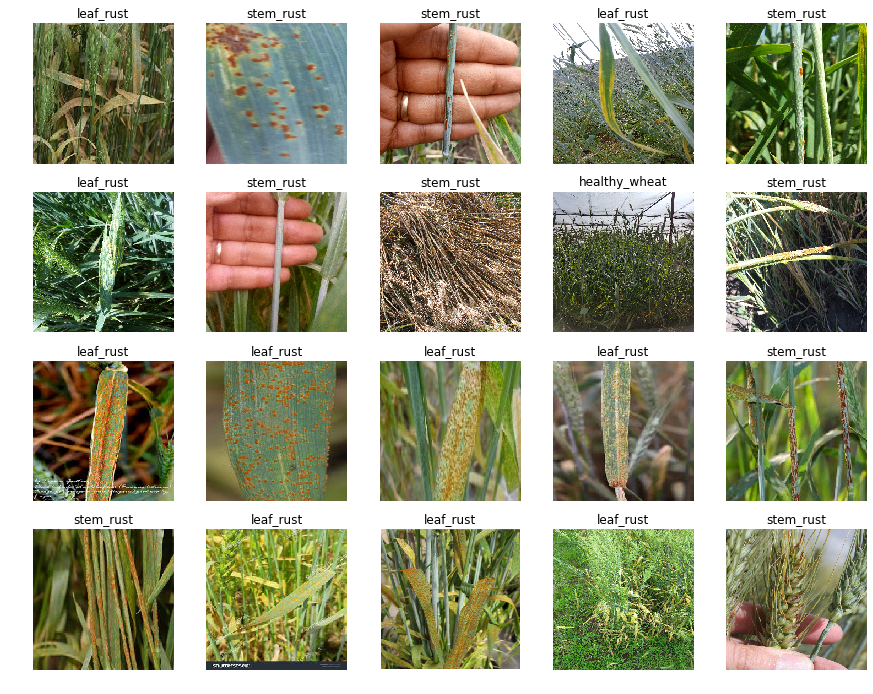

In [7]:
# a function to show the image batch
def show_batch_train_images(images,labels):
    plt.figure(figsize=(15,15))
    for n in range(20):
        ax = plt.subplot(5,5,n+1)
        index = int(random.random() * len(images))
        plt.imshow(images[index])
        plt.title(labels[index])
#         plt.title(CLASS_NAMES[labels[n]==1][0].title())
#         print("Size of this image is " + str(images[index].shape))
        plt.axis('off')

show_batch_train_images(train_images,train_labels)

### d) Categories of Training Images

In [8]:
#Categories of Images
pd.Series(train_labels).value_counts().reset_index().values.tolist()

[['stem_rust', 376], ['leaf_rust', 358], ['healthy_wheat', 142]]

Visualize the images distribution per label

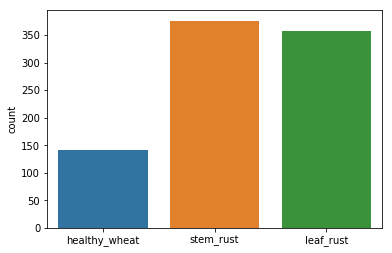

In [9]:
# Plot chart
sns.countplot(train_labels)
plt.show()

Above shows that the data is imbalanced since it's not evenly distributed across all classes Healthy wheat has the least number of photos while stemp rust has the largest number of photos

As data is imbalanced, class weight to be calculated and passed as argument during fitting of the model

In [10]:
#Class Weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels),
                                                 train_labels)

print(np.unique(train_labels))
class_weights

['healthy_wheat' 'leaf_rust' 'stem_rust']


array([2.05633803, 0.81564246, 0.77659574])

TO overcome class imbalances, below class weights will be applied to the model during fitting.

2.05: healthy wheat

0.81: leaf rust

0.77: stem rust

## 4.0 Images Pre-processing

In addition to images resizing done during importation, below preparation activities done before modelling.

#### a) Label Encoding. 

The train labels are string variables of three types i.e  healthy_wheat, stem_rust and leaf_rust. These are encoded to convert them to numerical Encoding will faciliate converting the labels to categorical variables

In [11]:
#Label encoding to change 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_enc = label_encoder.fit_transform(train_labels)
train_labels_enc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Convert the encoded dependent values to categorical types. Reason is because ANN works best with categorical values

In [12]:
#Convert the predicted labels to categorical type
train_labels_cat = to_categorical(train_labels_enc)

#Display the categorical training labels
print(train_labels_cat[1])
print(train_labels_cat[300])
print(train_labels_cat[600])

[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]


#### b) Normalization

Benefits of normalization
1. Reduce the effect of illumination's differences.
2. CNN converges faster on [0..1] data than on [0..255].

In [13]:
#Normalize the image pixels
train_images = train_images.astype('float32')/255 

#### c) Split the test and validation.

The validation set will be used to test overfitting in our model. The test images cannot be used as they do not have labels.**

In [14]:
# Training to have 90% and validation 10%. High value of training taken so that we have ample training images. 
# The more the images, the better the model
X_train,X_valid,Y_train,Y_valid = train_test_split(train_images,train_labels_cat,test_size = 0.1,random_state=None)

print("X Train count is ",len(X_train),"Shape",X_train.shape, " and Y train count ",len(Y_train), "Shape", Y_train.shape )
print("X validation count is ",len(X_valid), "Shape",X_valid.shape," and Y validation count ", len(Y_valid), "Shape",Y_valid.shape)

X Train count is  788 Shape (788, 256, 256, 3)  and Y train count  788 Shape (788, 3)
X validation count is  88 Shape (88, 256, 256, 3)  and Y validation count  88 Shape (88, 3)


## 5.0 Baseline Model

### Define the CNN model
Convolutional Neural Networks algorith was designed to map image data to an output variable hence is the best algorithm to use.

The benefit of using CNNs is their ability to develop an internal representation of a n-dimensional image. This allows the model to learn position and scale across different images, which is important when working with images.

In [15]:
#Define the CNN Model
#Sequential API to add one layer at a time starting from the input.
model = Sequential()
# Convolution layer with 32 filters first Conv2D layer.  
# Each filter transforms a part of the image using the kernel filter. The kernel filter matrix is applied on the whole image.
# Relu activation function used to add non linearity to the network.
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
# Convolution layer with 64 filters second Conv2D layer 
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# Max pooling applied. Reduces the size of the image by half. Is a downsampling filter which looks at the 2 neighboring pixels and picks the maximal value
model.add(MaxPool2D(pool_size=(2, 2)))
# Drop applied as a regularization method, where a proportion of nodes in the layer are randomly ignored by setting their wieghts to zero for each training sample.
# This drops randomly a proportion of the network and forces the network to learn features in a distributed way. This improves generalization and reduces overfitting.
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
# Flatten to convert the final feature maps into a one single 1D vector. Needed so as to make use of fully connected layers after some convolutional/maxpool layers.
# It combines all the found local features of the previous convolutional layers.
model.add(Flatten())
#Dense layer applied to create a fully-connected artificial neural networks classifier.
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
#Neural net outputs distribution of probability of each class.
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 123, 123, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 61, 61, 64)       

### Optimize and compile the model

OPTIMIZER: ADAM applied to minimize the loss function.

LOSS: categorical_crossentropy - multi-class log loss

Metrics: Categorical accuracy as it's classification problem

In [16]:
#Compilation of the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
                    loss=tf.keras.losses.categorical_crossentropy, 
                    metrics = [tf.keras.metrics.categorical_accuracy])

Training.

Class weight parameter specified for to rectify class imbalance

In [17]:
#Using ten epochs for the training and saving the accuracy for each epoch
history = model.fit(X_train, Y_train, batch_size=32, epochs=12,
                    validation_data=(X_valid, Y_valid),class_weight=class_weights) #,validation_split = 0.2, callbacks=callbacks,

Train on 788 samples, validate on 88 samples
Epoch 1/12
788/788 [==============================] - 7s 9ms/step - loss: 90.6716 - categorical_accuracy: 0.3617 - val_loss: 1.0249 - val_categorical_accuracy: 0.3864
Epoch 2/12
788/788 [==============================] - 3s 3ms/step - loss: 1.0310 - categorical_accuracy: 0.3934 - val_loss: 0.9837 - val_categorical_accuracy: 0.4886
Epoch 3/12
788/788 [==============================] - 3s 3ms/step - loss: 1.0354 - categorical_accuracy: 0.3997 - val_loss: 0.9950 - val_categorical_accuracy: 0.3864
Epoch 4/12
788/788 [==============================] - 3s 3ms/step - loss: 1.0341 - categorical_accuracy: 0.3718 - val_loss: 0.9912 - val_categorical_accuracy: 0.4886
Epoch 5/12
788/788 [==============================] - 3s 3ms/step - loss: 1.0330 - categorical_accuracy: 0.4061 - val_loss: 0.9922 - val_categorical_accuracy: 0.4886
Epoch 6/12
788/788 [==============================] - 3s 3ms/step - loss: 1.0293 - categorical_accuracy: 0.4074 - val_loss: 

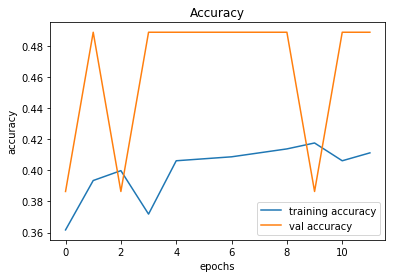

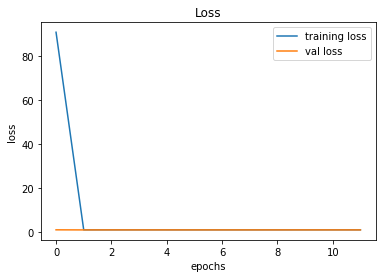

In [18]:
#Display of the accuracy and the loss values
plt.figure(0)
plt.plot(history.history['categorical_accuracy'], label='training accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Baseline Model Accuracy

In [19]:
# Create dictionary and dataframe to hold results for various models
dict = {'Model':['Baseline CNN' ,'Mobile Net V2', 'Data Augmentation'], 
        'AUC': [0,0,0],
        'Log Loss':[0,0,0], 
        'F1 score':[0,0,0], 
        'Recall':[0,0,0], 
        'Precision':[0,0,0]} 
df_results = pd.DataFrame(dict,columns = ['Model','Log Loss','AUC','F1 score','Recall','Precision'])


# Function to calculate Results for each model
def model_results(model_type,y_test_data, y_prediction_data, y_test_class, y_pred_class):
    
    index_val = df_results[df_results['Model']==model_type].index
    
    #Asign scores to dataframe
    df_results.loc[index_val,'AUC'] = roc_auc_score(y_test_data, y_prediction_data)
    df_results.loc[index_val,'Log Loss'] = log_loss(Y_valid, y_prediction_data)
    df_results.loc[index_val,'F1 score'] = f1_score(y_test_class, y_pred_class,average='weighted')
    df_results.loc[index_val,'Recall'] = recall_score(y_test_class, y_pred_class,average='weighted')
    df_results.loc[index_val,'Precision'] = precision_score(y_test_class, y_pred_class,average='weighted')

    return(df_results)

In [20]:
#Baseline Prediction
y_prediction = model.predict(X_valid) # make predictions

#Baseline Results
dominant_y_valid=np.argmax(Y_valid, axis=1)
dominant_y_predict=np.argmax(y_prediction, axis=1)

model_results('Baseline CNN',Y_valid, y_prediction,dominant_y_valid,dominant_y_predict)

,Model,Log Loss,AUC,F1 score,Recall,Precision
0,Baseline CNN,0.987865,0.5,0.320784,0.488636,0.238765
1,Mobile Net V2,0.000000,0.0,0.000000,0.000000,0.000000
2,Data Augmentation,0.000000,0.0,0.000000,0.000000,0.000000


In [21]:
#Confusion Matrix
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=75) 
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = range(3)
# cm = confusion_matrix(rounded_Y_valid , rounded_Y_predict_trf)
cm = confusion_matrix(dominant_y_valid , dominant_y_predict)
Y_valid, y_predict_trf
plt.figure(2)
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

NameError: name 'y_predict_trf' is not defined

## 6.0 Challenging the solution
### 6.1 Transfer Learning : Model to use is MobileNetV2

With transfer learning, instead of starting the learning process from scratch, you start from patterns that have been learned when solving a different problem. This way you leverage previous learnings and avoid starting from scratch.

More about MobileNetV2 here  - > https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html

a) Import the MobileNetV2 from keras

In [22]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=X_train.shape[1:],
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


b) Train The model

In [23]:
#To use weights in the pre-trained model
base_model.trainable = False 

#Define the pre-trained model
pretrained_model = tf.keras.Sequential([base_model,tf.keras.layers.GlobalAveragePooling2D(),tf.keras.layers.Dense(3, activation="softmax")])

pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss=tf.keras.losses.categorical_crossentropy, 
                         metrics = [tf.keras.metrics.categorical_accuracy])

pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


c) Fitting

In [24]:
#Fit the pretrained model to the  data
history_trf = pretrained_model.fit(X_train, Y_train, epochs=5,batch_size=32 , 
                validation_data=(X_valid, Y_valid), class_weight=class_weights)

Train on 788 samples, validate on 88 samples
Epoch 1/5
788/788 [==============================] - 5s 6ms/sample - loss: 1.5361 - categorical_accuracy: 0.5482 - val_loss: 0.9474 - val_categorical_accuracy: 0.6591
Epoch 2/5
788/788 [==============================] - 1s 2ms/sample - loss: 0.6597 - categorical_accuracy: 0.7475 - val_loss: 1.2258 - val_categorical_accuracy: 0.5909
Epoch 3/5
788/788 [==============================] - 1s 2ms/sample - loss: 0.4087 - categorical_accuracy: 0.8223 - val_loss: 1.2059 - val_categorical_accuracy: 0.5909
Epoch 4/5
788/788 [==============================] - 1s 2ms/sample - loss: 0.3964 - categorical_accuracy: 0.8503 - val_loss: 0.8488 - val_categorical_accuracy: 0.7386
Epoch 5/5
788/788 [==============================] - 1s 2ms/sample - loss: 0.3448 - categorical_accuracy: 0.8706 - val_loss: 1.7348 - val_categorical_accuracy: 0.5114


Graph of accuracy and loss for training and validation

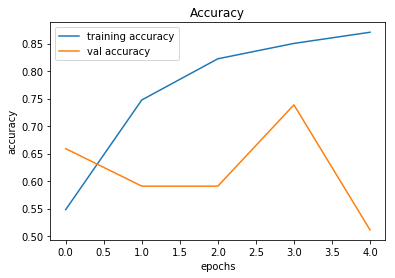

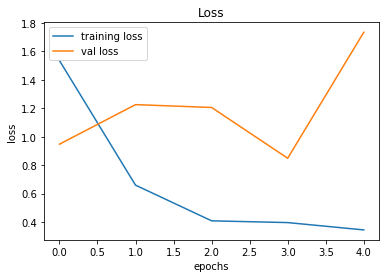

In [25]:
#Display of the accuracy and the loss values
plt.figure(0)
plt.plot(history_trf.history['categorical_accuracy'], label='training accuracy')
plt.plot(history_trf.history['val_categorical_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history_trf.history['loss'], label='training loss')
plt.plot(history_trf.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#### Mobile Net V2 Transfer Running Results
#### a) AUC and Log Loss

In [26]:
#Mobile Net V2 Prediction
y_prediction_trf = pretrained_model.predict(X_valid) # make predictions

#Baseline Results
dominant_y_valid=np.argmax(Y_valid, axis=1)
dominant_y_predict=np.argmax(y_prediction_trf, axis=1)

model_results('Mobile Net V2',Y_valid, y_prediction_trf,dominant_y_valid,dominant_y_predict)

,Model,Log Loss,AUC,F1 score,Recall,Precision
0,Baseline CNN,0.987865,0.500000,0.320784,0.488636,0.238765
1,Mobile Net V2,1.734819,0.822692,0.447748,0.511364,0.683586
2,Data Augmentation,0.000000,0.000000,0.000000,0.000000,0.000000


#### b) Classification Report

In [27]:
print(classification_report(dominant_y_valid , dominant_y_predict))

              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.45      0.97      0.62        34
           2       0.79      0.26      0.39        43

    accuracy                           0.51        88
   macro avg       0.75      0.44      0.39        88
weighted avg       0.68      0.51      0.45        88



#### Confusion Matrix

In [28]:
#Confusion Matrix
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=75) 
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = range(3)
# cm = confusion_matrix(rounded_Y_valid , rounded_Y_predict_trf)
cm = confusion_matrix(dominant_y_valid , dominant_y_predict)
Y_valid, y_predict_trf
plt.figure(2)
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, classes=class_names, title='Mobile Net V2 Confusion matrix')

NameError: name 'y_predict_trf' is not defined

### 6.2 Image Data Augmentation

We will generate more image data using ImageDataGenerator. The Image data generator package artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

In [29]:
# Generate more image data
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1/255, zoom_range = 0.3,horizontal_flip = True,rotation_range = 30)
val_generator = ImageDataGenerator(rescale = 1/255)
train_generator = train_generator.flow(np.array(X_train),Y_train,batch_size = 32,shuffle = False)
val_generator = val_generator.flow(np.array(X_valid),Y_valid,batch_size = 32,shuffle = False)

# Train and test the model
history_idg = pretrained_model.fit_generator(train_generator,
                                   epochs = 10,
                                   shuffle = False, 
                                   steps_per_epoch=3,
                                   validation_steps=1,
                                   validation_data=val_generator,
                                   class_weight=class_weights)

Train for 3 steps, validate for 1 steps
Epoch 1/10
3/3 [==============================] - 4s 1s/step - loss: 1.2725 - categorical_accuracy: 0.5521 - val_loss: 1.0599 - val_categorical_accuracy: 0.5625
Epoch 2/10
3/3 [==============================] - 1s 440ms/step - loss: 1.0639 - categorical_accuracy: 0.5938 - val_loss: 3.6209 - val_categorical_accuracy: 0.1875
Epoch 3/10
3/3 [==============================] - 2s 543ms/step - loss: 0.8112 - categorical_accuracy: 0.6979 - val_loss: 2.4641 - val_categorical_accuracy: 0.2500
Epoch 4/10
3/3 [==============================] - 2s 546ms/step - loss: 0.7874 - categorical_accuracy: 0.6771 - val_loss: 1.4511 - val_categorical_accuracy: 0.2500
Epoch 5/10
3/3 [==============================] - 2s 527ms/step - loss: 0.6731 - categorical_accuracy: 0.7604 - val_loss: 3.1780 - val_categorical_accuracy: 0.1875
Epoch 6/10
3/3 [==============================] - 2s 589ms/step - loss: 0.6939 - categorical_accuracy: 0.7500 - val_loss: 2.7738 - val_categori

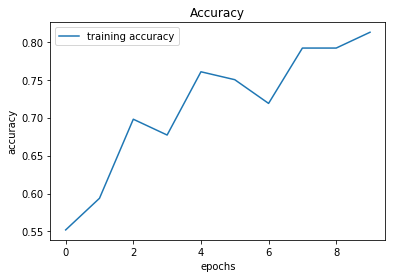

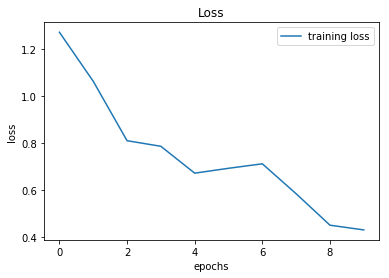

In [30]:
#Display of the accuracy and the loss values
plt.figure(0)
plt.plot(history_idg.history['categorical_accuracy'], label='training accuracy')
# plt.plot(history_idg.history['val_categorical_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history_idg.history['loss'], label='training loss')
# plt.plot(history_idg.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [31]:
# Prediction
y_prediction_idg = pretrained_model.predict(X_valid) # make predictions

logloss = log_loss(Y_valid, y_prediction_idg)
logloss

0.988418678176293

## 7.0 Subject the model to test data

a) Import the test data from test directory

In [32]:
#Function to upload the test images
def upload_test_images(image_path, height, width):
    test_images = []
    test_image_paths = []
        # Retrieve the filenames from the all the test directory
    test_image_file_names = [os.path.join(image_path, f) for f in os.listdir(image_path)]
        # Read the image pixels
    for file in test_image_file_names:
        test_image=io.imread(file)
        # Append image into list
        test_image_from_array = Image.fromarray(test_image, 'RGB')
        #Resize image
        test_size_image = test_image_from_array.resize((height, width))
        #Append image into list
        test_images.append(np.array(test_size_image))
        test_image_paths.append(file)
    return test_images,test_image_paths

## Invoke the function
#Image resize parameters
height = 256
width = 256
test_images,test_image_paths = upload_test_images('/kaggle/input/cgiar-computer-vision-for-crop-disease/ICLR/test/test/',height,width)
test_images = np.array(test_images)

In [33]:
#Size and dimension of test image
print("Shape of test images is " + str(test_images.shape))
# Check image paths
test_image_paths[0:5]

Shape of test images is (610, 256, 256, 3)


['/kaggle/input/cgiar-computer-vision-for-crop-disease/ICLR/test/test/FR69CL.JPG',
 '/kaggle/input/cgiar-computer-vision-for-crop-disease/ICLR/test/test/29QHAM.jfif',
 '/kaggle/input/cgiar-computer-vision-for-crop-disease/ICLR/test/test/X1UJGJ.jpg',
 '/kaggle/input/cgiar-computer-vision-for-crop-disease/ICLR/test/test/H3XNNP.jpg',
 '/kaggle/input/cgiar-computer-vision-for-crop-disease/ICLR/test/test/566UF3.JPG']

Image name is part of full image URL as above. We will seperate the name from the image path as below

In [34]:
# use regular expressions to extract the name of image
image_names = []
for i in test_image_paths:
#     name = i
    i = re.sub("[^A-Z0-9]", "", str(i))
    i = i.replace("JPG", "")
    i = i.replace("PNG", "")
    i = i.replace("JPEG", "")
    i = i.replace("JFIF", "")
    i = i.replace("JFIF", "")
    i.strip()
    image_names.append(i)

#View images
image_names[0:5]

['ICLRFR69CL', 'ICLR29QHAM', 'ICLRX1UJGJ', 'ICLRH3XNNP', 'ICLR566UF3']

In [35]:
#Prediction for all images
y_prediction = model.predict_proba(test_images) # make predictions
y_prediction[400:500]

array([[0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.16435553, 0.41142982, 0.4242146 ],
       [0.

In [36]:
# Prediction for all images per test image
test_images = np.array(test_images)
preds = []
for img in tqdm(test_images):
    img = img[np.newaxis,:] # add a new dimension
    prediction = pretrained_model.predict_proba(img) # make predictions predict_proba
    preds.append(prediction) 
preds

100%|██████████| 610/610 [00:26<00:00, 22.78it/s]


[array([[0.01325326, 0.06108984, 0.92565686]], dtype=float32),
 array([[4.3662047e-05, 1.1337075e-03, 9.9882263e-01]], dtype=float32),
 array([[0.01423639, 0.02363031, 0.9621332 ]], dtype=float32),
 array([[0.0382036 , 0.11904639, 0.84275   ]], dtype=float32),
 array([[0.0250155 , 0.10987446, 0.86511004]], dtype=float32),
 array([[0.02491169, 0.1909088 , 0.7841795 ]], dtype=float32),
 array([[0.1711891 , 0.11318617, 0.7156247 ]], dtype=float32),
 array([[0.01512377, 0.02266535, 0.96221083]], dtype=float32),
 array([[0.00316839, 0.01888968, 0.97794193]], dtype=float32),
 array([[0.00650751, 0.00889411, 0.9845984 ]], dtype=float32),
 array([[2.861266e-04, 4.324146e-03, 9.953897e-01]], dtype=float32),
 array([[0.00322624, 0.03098046, 0.96579325]], dtype=float32),
 array([[0.05867939, 0.7074218 , 0.23389886]], dtype=float32),
 array([[0.01482605, 0.02686466, 0.95830923]], dtype=float32),
 array([[0.02139816, 0.01635029, 0.96225154]], dtype=float32),
 array([[0.00285379, 0.03366929, 0.96347

In [37]:
#healthwheat =0 stem_rust = 2 ,leaf_rst =1
# create a dummy dataset
healthy_wheat = pd.Series(range(610), name="healthy_wheat", dtype=np.float32)
stem_rust = pd.Series(range(610), name="stem_rust", dtype=np.float32)
leaf_rust = pd.Series(range(610), name="leaf_rust", dtype=np.float32)
submission = pd.concat([healthy_wheat,stem_rust,leaf_rust], axis=1)

for i in range(0 ,len(preds)):
    submission.loc[i] = preds[i]

In [38]:
#Append the image names to the result output
submission["ID"] = image_names

In [39]:
submission

,healthy_wheat,stem_rust,leaf_rust,ID
0,0.013253,0.061090,0.925657,ICLRFR69CL
1,0.000044,0.001134,0.998823,ICLR29QHAM
2,0.014236,0.023630,0.962133,ICLRX1UJGJ
3,0.038204,0.119046,0.842750,ICLRH3XNNP
4,0.025015,0.109874,0.865110,ICLR566UF3
5,0.024912,0.190909,0.784180,ICLRV66D9F
6,0.171189,0.113186,0.715625,ICLR7FRVBT
7,0.015124,0.022665,0.962211,ICLRXVZ454
8,0.003168,0.018890,0.977942,ICLRXRFFAM
9,0.006508,0.008894,0.984598,ICLRLL93NP


Results

a) To upload the above submission on zindi so as to get the outcome versus test.

b) Combine image data augmentation and 